In [1]:
"""Notebok loads raw simulation data & prepares a dataset ready for training.
"""

'Notebok loads raw simulation data & prepares a dataset ready for training.\n'

In [98]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.special import inv_boxcox
from sklearn.model_selection import train_test_split
from typing import Type, List

In [3]:
def extract_step_temperatures(simulation_path: pathlib.Path) -> Type[pd.DataFrame]:
    """Extracts step temperatures from a single .MSG file in a simulation folder.

    Args:
        simulation_path: Absolute path to the simulation folder.

    Return:
        Step - temperature DataFrame.
    """
    print("Extracting step temperatures for simulation: ", simulation_path.name)

    # Find the largest .MSH file.
    msg_files = []
    for path in simulation_path.rglob('*'):
        if path.suffix == '.MSG':
            msg_files.append(path)

    msg_file = msg_files[0]

    if len(msg_files) > 1:
        print("There is more than 1 .MSG file in the simulation folder! Parsing only the largest one!")
        file_sizes = []
        for msg_file in msg_files:
            file_size_bytes = msg_file.stat().st_size
            file_sizes.append(file_size_bytes)
        print("msg_files and sizes: ", msg_files, file_sizes)
        file_sizes = np.array(file_sizes)
        msg_file = msg_files[np.argmax(file_sizes)]
        
    if len(msg_files) <= 0:
        print("No .MSG files found in the simulation folder! Invalid dataset could be produced!")

    # Read all the lines of the .MSG & isolate steps and temperatures.
    with open(msg_file, 'r') as f:
        lines = f.readlines()
    lines = [line.strip() for line in lines]

    step_temperatures = {}
    step_count = 0
    step = None
    temperature = None
    for line_idx, line in enumerate(lines):
        if 'TEMPERATURE CALCULATION FOR STEP :' in line:
            step = int(line.split()[-1]) # Step number is expected to be last entry.
            step_count += 1
        if 'TEMPERATURE ITERATION' in line:
            # Only first temperature iteration is considered.
            temperature = lines[line_idx + 5] # Expected to be 5 lines below.
            temperature = temperature.split()[1] 
            temperature = float(temperature)
        if step and temperature:
            step_temperatures[step] = temperature

    if step_count != len(step_temperatures):
        print(f".MSG file has unmatched number of steps and temperature calculations! Steps: {step_count}, Temperatures: {len(step_temperatures)}")

    # Create the output DataFrame.
    df = pd.json_normalize(step_temperatures)
    
    df = df.T
    df = df.sort_index(ascending=True)
    df.index.rename("step", inplace=True)
    df.rename(columns = {0: "temperature"}, inplace=True)
    
    return df

In [4]:
def parse_and_process_data_sheet(spread_sheet_path: pathlib.Path, simulation: str) -> Type[pd.DataFrame]:
    """Parses and pre-processes input data sheet for a given simulation. Function expects that the input spread sheet
    contains a sheet for each simulation.

    Args:
        spread_sheet_path: Absolute path to the spreadsheet.
        simulation: Name of the simulation sheet.

    Return:
        Simulation DataFrame.
    """
    print("Parsing the data sheet for simulation: ", simulation)
    
    try:
        df = pd.read_excel(spread_sheet_path, header = 0, na_values='--', verbose=True, sheet_name=simulation)
    except ValueError:
        print("Invalid sheet name!")
    
    # Try with upper case simulation name.
    try:
        df = pd.read_excel(spread_sheet_path, header = 0, na_values='--', verbose=True, sheet_name=simulation.upper()) 
    except ValueError:
        print("Invalid sheet name!")

    # Remove reduntant features.
    # There are several redundant features that do not add information.
    # Time, as it is just the time od of the simulation step.
    # Simulation steps, also do not contain information and are only applicable in simulation environment.
    # Nofsimnum has only 1s - does not contain information.
    df = df.loc[:, df.columns != 'Time']
    df = df.loc[:, df.columns != 'Step No.']
    df = df.loc[:, df.columns != 'Nofsimnum']

    # Clean the NaN values.
    df = df.dropna()

    return df

In [5]:
def merge_dfs(step_temperatures: Type[pd.DataFrame], 
              simulation_data_sheet: Type[pd.DataFrame], 
              simulation: str) -> Type[pd.DataFrame]:
    """Merges the step temperature and simulation data sheet data for a single simulation.
    
    Args:
        step_temperatures: Step-temperature data.
        simulation_data_sheet: Simulation data.
        simulation: Name of the simulation.

    Returns:
        Merged dataframe.
    """
    print(f"Merging the step-temperature and simulation data sheet for simulation {simulation}!")    
    if len(step_temperatures) != len(simulation_data_sheet):
        print(f"Temperature is not available for all the steps of the simulation {simulation}! Only steps with computed temperature will be"
              f"taken into account")
        print("No. of steps: ", len(step_temperatures))
        print("No. of simulation steps: ", len(simulation_data_sheet))

    # Find the largest overlap of simulation steps, in case the simulation_data_sheet has less steps then the step-temperatures.
    simulation_data_sheet_indices = simulation_data_sheet.index.to_numpy()
    step_temperatures_indices = step_temperatures.index.to_numpy()

    merged_indices = np.intersect1d(simulation_data_sheet_indices, step_temperatures_indices)

    merged_df = simulation_data_sheet.loc[merged_indices] # loc is label based, so it start from 1 in this case!

    # Insert a temperature column.
    merged_df.insert(loc = 0,
              column = 'Temperature',
              value = step_temperatures['temperature'])

    return merged_df

In [6]:
def plot_heatmap(x: np.ndarray, labels: List[str], title: str) -> None:
    """Plots a symmetrical 2D heatmap of the input data.
    
    Args:
        x: Input data, has to be a symmetrical 2D array.
        labels: Labels of the data.
        title: Title of the heatmap.
    """
    fig, ax = plt.subplots()
    im = ax.imshow(x, cmap='hot')

    # Set the tick labels.
    ax.set_xticks(np.arange(len(labels)), labels=labels)
    ax.set_yticks(np.arange(len(labels)), labels=labels)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right',
             rotation_mode='anchor')

    # Create data annotations.
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, x[i, j],
                           ha='center', va='center', color='g', fontsize = 8)
            
    ax.set_title(f'{title} - Heatmnap')

    plt.show()

# Load the input data

In [7]:
# Dataset is created out of multiple simulation data. Each simulation data has it's folder 
# (with relevant .MSG file - containing temperatures) and corresponding .xlsx sheet
# (with output variables - load x and y, and other input variables - depth of cut, feed rate, length of cut).
simulations = [
    'v1',
    'v2',
    'v3',
    'v10',
    'v11',
    'v12',
    'v13',
    'v14',
    'v15',
    'v16'
] 

In [8]:
simulations_path = pathlib.Path('./data/simulations')
spread_sheet_path = pathlib.Path('./data/Thesis All Data Last.xlsx')

# Parse the .MSG files

In [9]:
example_simulation_idx = 1

In [10]:
simulation_path = simulations_path / pathlib.Path(simulations[example_simulation_idx])
print("Simulation: ", simulations[example_simulation_idx])

Simulation:  v2


In [11]:
msg_files = []
for path in simulation_path.rglob('*'):
    if path.suffix == '.MSG':
        msg_files.append(path)

In [12]:
msg_file = msg_files[0]

if len(msg_files) > 1:
    print("There is more than 1 .MSG file in the simulation folder! Parsing only the largest one!")
    file_sizes = []
    for msg_file in msg_files:
        file_size_bytes = msg_file.stat().st_size
        file_sizes.append(file_size_bytes)
    print("msg_files and sizes: ", msg_files, file_sizes)
    file_sizes = np.array(file_sizes)
    msg_file = msg_files[np.argmax(file_sizes)]
    
if len(msg_files) <= 0:
    print("No .MSG files found in the simulation folder! Invalid dataset could be produced!")

In [13]:
# Read all the lines of the .MSG & isolate steps and temperatures.
with open(msg_file, 'r') as f:
    lines = f.readlines()
lines = [line.strip() for line in lines]

In [14]:
step_temperatures = {}
step_count = 0
step = None
temperature = None
for line_idx, line in enumerate(lines):
    if 'TEMPERATURE CALCULATION FOR STEP :' in line:
        step = int(line.split()[-1]) # Step number is expected to be last entry.
        step_count += 1
    if 'TEMPERATURE ITERATION' in line:
        # Only first temperature iteration is considered.
        temperature = lines[line_idx + 5] # Expected to be 5 lines below.
        temperature = temperature.split()[1]
        temperature = float(temperature)

    if step and temperature:
        step_temperatures[step] = temperature

In [15]:
if step_count != len(step_temperatures):
    print(f".MSG file has unmatched number of steps and temperature calculations! Steps: {step_count}, Temperatures: {len(step_temperatures)}")

In [16]:
# Create the output DataFrame.
df = pd.json_normalize(step_temperatures)

In [17]:
df = df.T
df = df.sort_index(ascending=True)
df.index.rename("step", inplace=True)
df.rename(columns = {0: "temperature"}, inplace=True)

In [18]:
df

,temperature
step,
1,2011.467126
2,2014.513224
3,2014.976244
4,2015.108007
5,2016.710887
...,...
206,4371.465944
207,4381.667321
208,4389.571290


In [19]:
# Do it for all the simulations.
step_temperatures_dfs = {}
for simulation in simulations:
    simulation_path = simulations_path / pathlib.Path(simulation)
    df = extract_step_temperatures(simulation_path)
    step_temperatures_dfs[simulation] = df

Extracting step temperatures for simulation:  v1
Extracting step temperatures for simulation:  v2
Extracting step temperatures for simulation:  v3
There is more than 1 .MSG file in the simulation folder! Parsing only the largest one!
msg_files and sizes:  [PosixPath('data/simulations/v3/Tez_v3.MSG'), PosixPath('data/simulations/v3/INTVAR.MSG')] [36195, 136]
Extracting step temperatures for simulation:  v10
There is more than 1 .MSG file in the simulation folder! Parsing only the largest one!
msg_files and sizes:  [PosixPath('data/simulations/v10/INTVAR.MSG'), PosixPath('data/simulations/v10/v10.MSG')] [136, 321144]
Extracting step temperatures for simulation:  v11
There is more than 1 .MSG file in the simulation folder! Parsing only the largest one!
msg_files and sizes:  [PosixPath('data/simulations/v11/INTVAR.MSG'), PosixPath('data/simulations/v11/v11.MSG')] [136, 395362]
Extracting step temperatures for simulation:  v12
There is more than 1 .MSG file in the simulation folder! Parsing

In [20]:
step_temperatures_dfs[simulations[example_simulation_idx]]

,temperature
step,
1,2011.467126
2,2014.513224
3,2014.976244
4,2015.108007
5,2016.710887
...,...
206,4371.465944
207,4381.667321
208,4389.571290


# Parse the data sheet

In [21]:
try:
    df = pd.read_excel(spread_sheet_path, header = 0, na_values='--', verbose=True, sheet_name=simulations[example_simulation_idx])
except ValueError:
    print("Invalid sheet name!")

# Try with upper case simulation name.
try:
    df = pd.read_excel(spread_sheet_path, header = 0, na_values='--', verbose=True, sheet_name=simulations[example_simulation_idx].upper()) 
except ValueError:
    print("Invalid sheet name!")

Reading sheet v2
Invalid sheet name!
Reading sheet V2


In [22]:
df.head()

,Depth Of Cut,Feed Rate,Lenght Of Cut,Nofsimnum,Step No.,Time,Load X,Load Y
0,0.5,0.2,1,1,-1,0.000000,NaN,NaN
1,0.5,0.2,1,1,1,136680.987801,598346.0,671413.0
2,0.5,0.2,1,1,2,179087.315076,767689.0,738346.0
3,0.5,0.2,1,1,3,213728.844488,889873.0,138438.0
4,0.5,0.2,1,1,4,2483.703739,960976.0,14598.0


In [23]:
len(df)

210

In [24]:
# There are several redundant features that do not add information.
# Time, as it is just the time od of the simulation step.
# Simulation steps, also do not contain information and are only applicable in simulation environment.
# Nofsimnum has only 1s - does not contain information.
df['Nofsimnum'].unique()

array([1])

In [25]:
# Remove reduntant features.
df = df.loc[:, df.columns != 'Time']
df = df.loc[:, df.columns != 'Step No.']
df = df.loc[:, df.columns != 'Nofsimnum']

In [26]:
df.head()

,Depth Of Cut,Feed Rate,Lenght Of Cut,Load X,Load Y
0,0.5,0.2,1,NaN,NaN
1,0.5,0.2,1,598346.0,671413.0
2,0.5,0.2,1,767689.0,738346.0
3,0.5,0.2,1,889873.0,138438.0
4,0.5,0.2,1,960976.0,14598.0


In [27]:
# Clean the NaN values.
df = df.dropna()

In [28]:
len(df)

209

In [29]:
df.head()

,Depth Of Cut,Feed Rate,Lenght Of Cut,Load X,Load Y
1,0.5,0.2,1,598346.0,671413.0
2,0.5,0.2,1,767689.0,738346.0
3,0.5,0.2,1,889873.0,138438.0
4,0.5,0.2,1,960976.0,14598.0
5,0.5,0.2,1,998679.0,141208.0


In [30]:
df.tail()

,Depth Of Cut,Feed Rate,Lenght Of Cut,Load X,Load Y
205,0.5,0.2,1,354944.00,188467.0
206,0.5,0.2,1,356115.00,190237.0
207,0.5,0.2,1,357.55,192446.0
208,0.5,0.2,1,358412.00,194757.0
209,0.5,0.2,1,360227.00,196576.0


In [31]:
# Do it for all the simulations.
simulation_data_sheet_dfs = {}
for simulation in simulations:
    df = parse_and_process_data_sheet(spread_sheet_path, simulation)
    simulation_data_sheet_dfs[simulation] = df

Parsing the data sheet for simulation:  v1
Reading sheet v1
Invalid sheet name!
Reading sheet V1
Parsing the data sheet for simulation:  v2
Reading sheet v2
Invalid sheet name!
Reading sheet V2
Parsing the data sheet for simulation:  v3
Reading sheet v3
Invalid sheet name!
Reading sheet V3
Parsing the data sheet for simulation:  v10
Reading sheet v10
Invalid sheet name!
Reading sheet V10
Parsing the data sheet for simulation:  v11
Reading sheet v11
Invalid sheet name!
Reading sheet V11
Parsing the data sheet for simulation:  v12
Reading sheet v12
Invalid sheet name!
Reading sheet V12
Parsing the data sheet for simulation:  v13
Reading sheet v13
Invalid sheet name!
Reading sheet V13
Parsing the data sheet for simulation:  v14
Reading sheet v14
Invalid sheet name!
Reading sheet V14
Parsing the data sheet for simulation:  v15
Reading sheet v15
Invalid sheet name!
Reading sheet V15
Parsing the data sheet for simulation:  v16
Reading sheet v16
Invalid sheet name!
Reading sheet V16


In [32]:
simulation_data_sheet_dfs[simulations[example_simulation_idx]].head()

,Depth Of Cut,Feed Rate,Lenght Of Cut,Load X,Load Y
1,0.5,0.2,1,598346.0,671413.0
2,0.5,0.2,1,767689.0,738346.0
3,0.5,0.2,1,889873.0,138438.0
4,0.5,0.2,1,960976.0,14598.0
5,0.5,0.2,1,998679.0,141208.0


In [33]:
len(simulation_data_sheet_dfs[simulations[example_simulation_idx]])

209

# Merge the step temperatures and data sheets

In [34]:
if len(step_temperatures_dfs) != len(simulation_data_sheet_dfs):
    print("Number of extracted step - temperatures pairs is not the same as the number of extracted simulation data sheets!")
    print("No. of step-temperature pairs: ", len(step_temperatures_dfs))
    print("No. of simulation data sheets: ", len(simulation_data_sheet_dfs))

In [35]:
# Get the corresponding step-temperatures and simulation data sheets.
simulation = simulations[1]
step_temperatures = step_temperatures_dfs[simulation]
simulation_data_sheet = simulation_data_sheet_dfs[simulation]

if len(step_temperatures) != len(simulation_data_sheet):
    print(f"Temperature is not available for all the steps of the simulation {simulation}! Only steps with computed temperature will be"
          f"taken into account")
    print("No. of steps: ", len(step_temperatures))
    print("No. of simulation steps: ", len(simulation_data_sheet))

Temperature is not available for all the steps of the simulation v2! Only steps with computed temperature will betaken into account
No. of steps:  210
No. of simulation steps:  209


In [86]:
# step_temperatures.index.to_list()

In [37]:
simulation_data_sheet

,Depth Of Cut,Feed Rate,Lenght Of Cut,Load X,Load Y
1,0.5,0.2,1,598346.00,671413.0
2,0.5,0.2,1,767689.00,738346.0
3,0.5,0.2,1,889873.00,138438.0
4,0.5,0.2,1,960976.00,14598.0
5,0.5,0.2,1,998679.00,141208.0
...,...,...,...,...,...
205,0.5,0.2,1,354944.00,188467.0
206,0.5,0.2,1,356115.00,190237.0
207,0.5,0.2,1,357.55,192446.0
208,0.5,0.2,1,358412.00,194757.0


In [38]:
# Find the largest overlap of simulation steps, in case the simulation_data_sheet has less steps then the step-temperatures.
simulation_data_sheet_indices = simulation_data_sheet.index.to_numpy()
step_temperatures_indices = step_temperatures.index.to_numpy()

In [39]:
merged_indices = np.intersect1d(simulation_data_sheet_indices, step_temperatures_indices)

In [40]:
merged_indices

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [41]:
merged_df = simulation_data_sheet.loc[merged_indices] # loc is label based, so it start from 1 in this case!

In [42]:
merged_df

,Depth Of Cut,Feed Rate,Lenght Of Cut,Load X,Load Y
1,0.5,0.2,1,598346.00,671413.0
2,0.5,0.2,1,767689.00,738346.0
3,0.5,0.2,1,889873.00,138438.0
4,0.5,0.2,1,960976.00,14598.0
5,0.5,0.2,1,998679.00,141208.0
...,...,...,...,...,...
205,0.5,0.2,1,354944.00,188467.0
206,0.5,0.2,1,356115.00,190237.0
207,0.5,0.2,1,357.55,192446.0
208,0.5,0.2,1,358412.00,194757.0


In [43]:
# Insert a temperature column.
merged_df.insert(loc = 0,
          column = 'Temperature',
          value = step_temperatures['temperature'])

In [44]:
merged_df

,Temperature,Depth Of Cut,Feed Rate,Lenght Of Cut,Load X,Load Y
1,2011.467126,0.5,0.2,1,598346.00,671413.0
2,2014.513224,0.5,0.2,1,767689.00,738346.0
3,2014.976244,0.5,0.2,1,889873.00,138438.0
4,2015.108007,0.5,0.2,1,960976.00,14598.0
5,2016.710887,0.5,0.2,1,998679.00,141208.0
...,...,...,...,...,...,...
205,4361.869553,0.5,0.2,1,354944.00,188467.0
206,4371.465944,0.5,0.2,1,356115.00,190237.0
207,4381.667321,0.5,0.2,1,357.55,192446.0
208,4389.571290,0.5,0.2,1,358412.00,194757.0


In [45]:
# Do it for all the simulations = prepare the dataset.
dataset_df_raw = pd.DataFrame()
for simulation in simulations:
    # Get the corresponding step-temperatures and simulation data sheets.
    step_temperatures = step_temperatures_dfs[simulation]
    simulation_data_sheet = simulation_data_sheet_dfs[simulation]
    merged_df = merge_dfs(step_temperatures, simulation_data_sheet, simulation)
    dataset_df_raw = pd.concat([dataset_df_raw, merged_df])

Merging the step-temperature and simulation data sheet for simulation v1!
Merging the step-temperature and simulation data sheet for simulation v2!
Temperature is not available for all the steps of the simulation v2! Only steps with computed temperature will betaken into account
No. of steps:  210
No. of simulation steps:  209
Merging the step-temperature and simulation data sheet for simulation v3!
Temperature is not available for all the steps of the simulation v3! Only steps with computed temperature will betaken into account
No. of steps:  15
No. of simulation steps:  662
Merging the step-temperature and simulation data sheet for simulation v10!
Temperature is not available for all the steps of the simulation v10! Only steps with computed temperature will betaken into account
No. of steps:  100
No. of simulation steps:  590
Merging the step-temperature and simulation data sheet for simulation v11!
Temperature is not available for all the steps of the simulation v11! Only steps with

In [224]:
dataset_df_raw.head()

,Temperature,Depth Of Cut,Feed Rate,Lenght Of Cut,Load X,Load Y
1,2011.467126,0.2,0.2,1.5,598346.0,671413.0
2,2014.513224,0.2,0.2,1.5,767689.0,738346.0
3,2014.976244,0.2,0.2,1.5,889873.0,138438.0
4,2015.108007,0.2,0.2,1.5,960976.0,14598.0
5,2016.710887,0.2,0.2,1.5,998679.0,141208.0


# Normalize, visualize and export

In [225]:
# Compute basic statistics for different variables in the dataset.
dataset_df_raw.describe()

,Temperature,Depth Of Cut,Feed Rate,Lenght Of Cut,Load X,Load Y
count,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000
mean,2692.098038,0.345603,0.181596,1.359112,244974.863844,376696.265352
std,1556.426264,0.116225,0.051090,0.238655,179456.879596,299788.609445
min,1300.307656,0.200000,0.100000,1.000000,49.780000,0.782819
25%,2097.825635,0.200000,0.150000,1.000000,154605.500000,126048.500000
50%,2333.847117,0.300000,0.200000,1.500000,222856.000000,231165.000000
75%,2789.895361,0.450000,0.200000,1.500000,300831.000000,651220.000000
max,15091.871290,0.500000,0.500000,1.600000,998679.000000,999488.000000


Text(0.5, 1.0, 'Load Y')

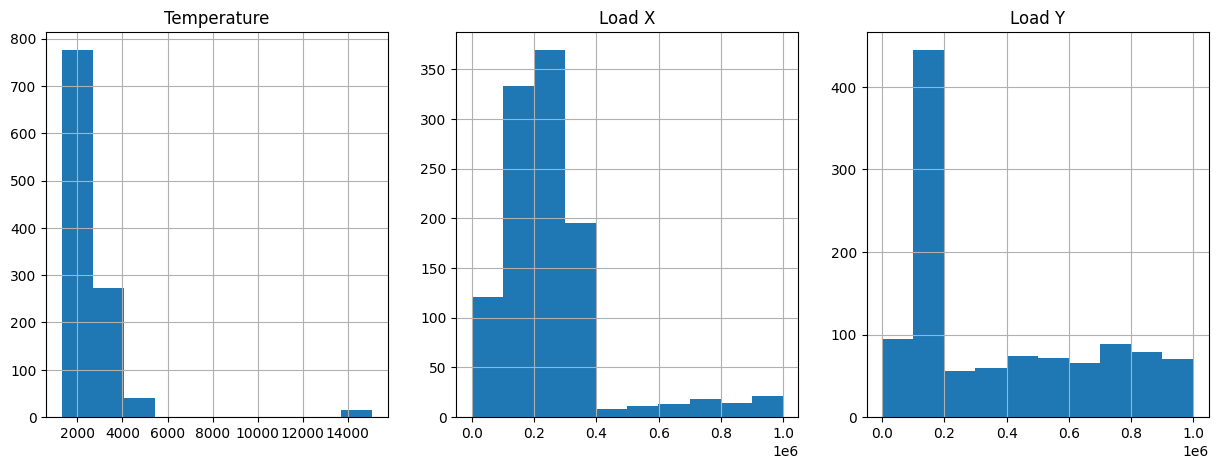

In [226]:
# Display distributions of Temperature and 2 output variables.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

dataset_df_raw["Temperature"].hist(ax=ax1)
ax1.set_title('Temperature')

dataset_df_raw["Load X"].hist(ax=ax2)
ax2.set_title('Load X')

dataset_df_raw["Load Y"].hist(ax=ax3)
ax3.set_title('Load Y')

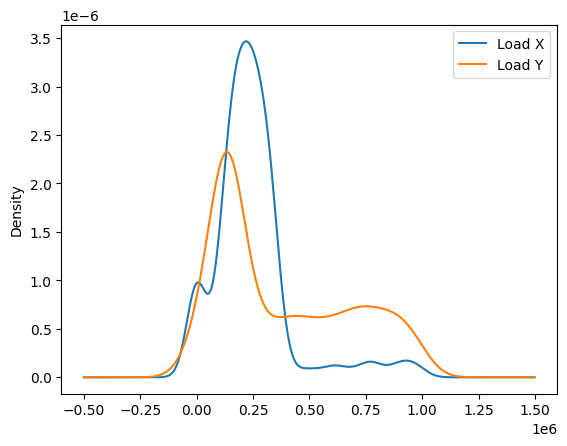

In [227]:
dataset_df_raw.plot(x="Temperature", y=["Load X", "Load Y"], kind='kde')
plt.show()

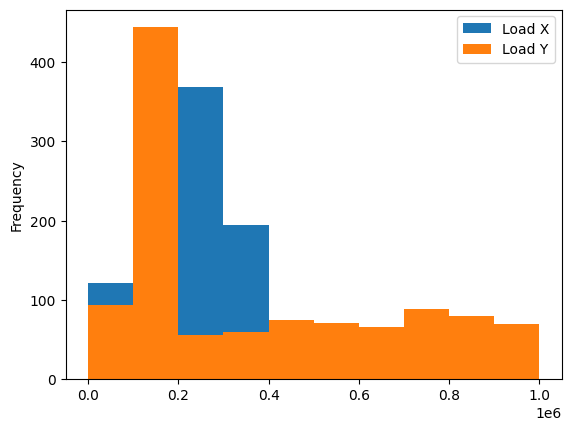

In [228]:
dataset_df_raw.plot(x="Temperature", y=["Load X", "Load Y"], kind='hist')
plt.show()

In [229]:
# Do a BoxCox transformations to achieve a more Gaussian distributions.
dataset_transformed_df = dataset_df_raw.copy()
dataset_transformed_df['Temperature'], lambda_temp = stats.boxcox(dataset_transformed_df['Temperature'])
dataset_transformed_df['Load X'], lambda_load_x = stats.boxcox(dataset_transformed_df['Load X'])
dataset_transformed_df['Load Y'], lambda_load_y = stats.boxcox(dataset_transformed_df['Load Y'])

Text(0.5, 1.0, 'Load Y')

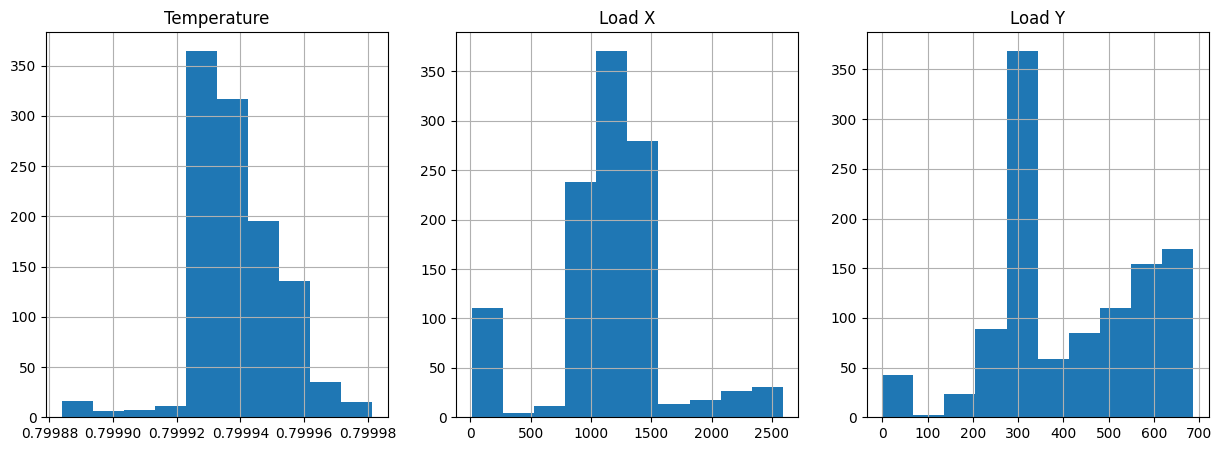

In [230]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

dataset_transformed_df["Temperature"].hist(ax=ax1)
ax1.set_title('Temperature')

dataset_transformed_df["Load X"].hist(ax=ax2)
ax2.set_title('Load X')

dataset_transformed_df["Load Y"].hist(ax=ax3)
ax3.set_title('Load Y')

In [231]:
# Print out the BoxCox transformation lambda parameters, to inverse the transformatio during the evaluation.
print("Lambda Temperature: ", lambda_temp)
print("Lambda Load X: ", lambda_load_x)
print("Lambda Load Y: ", lambda_load_y)

Lambda Temperature:  -1.250021464440798
Lambda Load X:  0.5219071729291129
Lambda Load Y:  0.40813414622179595


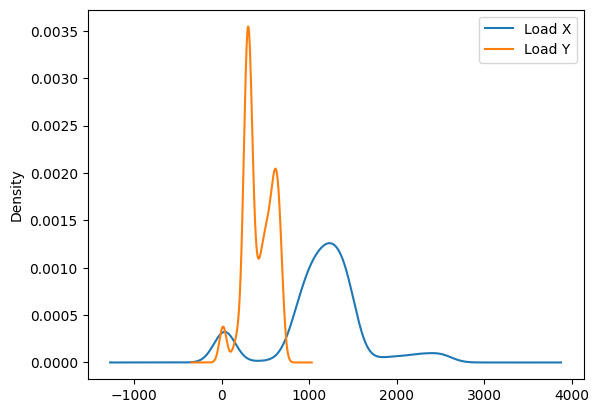

In [232]:
dataset_transformed_df.plot(x="Temperature", y=["Load X", "Load Y"], kind='kde')
plt.show()

In [233]:
# Clean the outliers using IQR method.
# Outliers are defined as those outside of range defined by (1.5 x IQR + Q3) and (1.5 x IQR - Q1).
def clean_iqr_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3-q1

    df = df.loc[lambda df: ~((df[column] < (q1 - 1.5*iqr)) | (df[column] > (q3 + 1.5*iqr)))]
    
    return df

In [234]:
iqr_iterations = 3
for _ in range(iqr_iterations):
    dataset_transformed_df = clean_iqr_outliers(dataset_transformed_df, 'Load X')
    dataset_transformed_df = clean_iqr_outliers(dataset_transformed_df, 'Load Y')
    dataset_transformed_df = clean_iqr_outliers(dataset_transformed_df, 'Temperature')

Text(0.5, 1.0, 'Load Y')

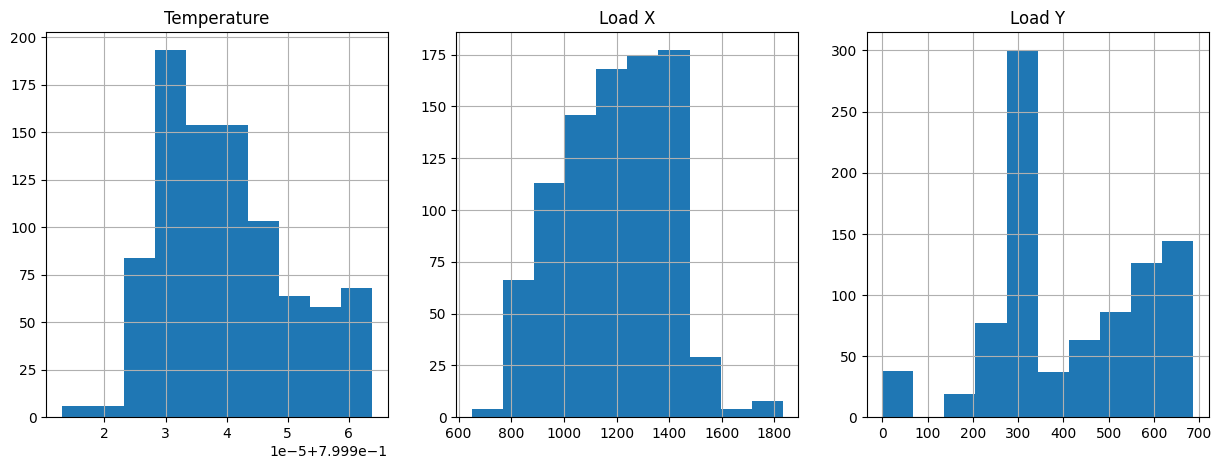

In [235]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

dataset_transformed_df["Temperature"].hist(ax=ax1)
ax1.set_title('Temperature')

dataset_transformed_df["Load X"].hist(ax=ax2)
ax2.set_title('Load X')

dataset_transformed_df["Load Y"].hist(ax=ax3)
ax3.set_title('Load Y')

In [236]:
# Extrapolate relevant min and max values for reverse transformations during evaluation.
print("Minimal Temperature: ", dataset_transformed_df["Temperature"].min())
print("Maximal Temperature: ", dataset_transformed_df["Temperature"].max())
print("Minimal Load X: ", dataset_transformed_df["Load X"].min())
print("Maximal Load X: ", dataset_transformed_df["Load X"].max())
print("Minimal Load Y: ", dataset_transformed_df["Load Y"].min())
print("Maximal Load Y: ", dataset_transformed_df["Load Y"].max())

Minimal Temperature:  0.7999129740607918
Maximal Temperature:  0.79996392605093
Minimal Load X:  650.3838414957692
Maximal Load X:  1831.6845429765622
Minimal Load Y:  -0.23301682607607901
Maximal Load Y:  686.0612810310728


In [237]:
def normalize_min_max(df, var_name):
    df[var_name]=(df[var_name]-df[var_name].min())/(df[var_name].max()-df[var_name].min())
    return df

In [238]:
# Normalize the variables that are not in the 0-1 range, except the Length of Cut as it is not too large.
dataset_transformed_df = normalize_min_max(dataset_transformed_df, 'Temperature')
dataset_transformed_df = normalize_min_max(dataset_transformed_df, 'Load X')
dataset_transformed_df = normalize_min_max(dataset_transformed_df, 'Load Y')

In [239]:
dataset_transformed_df.describe()

,Temperature,Depth Of Cut,Feed Rate,Lenght Of Cut,Load X,Load Y
count,890.000000,890.000000,890.000000,890.000000,890.000000,890.000000
mean,0.533272,0.344775,0.179551,1.357191,0.461797,0.607139
std,0.207130,0.115713,0.032652,0.240310,0.174257,0.247626
min,0.000000,0.200000,0.100000,1.000000,0.000000,0.000000
25%,0.363543,0.200000,0.150000,1.000000,0.324390,0.425502
50%,0.500254,0.300000,0.200000,1.500000,0.473182,0.532778
75%,0.671287,0.450000,0.200000,1.500000,0.596927,0.852903
max,1.000000,0.500000,0.200000,1.600000,1.000000,1.000000


In [240]:
dataset_transformed_df.head()

,Temperature,Depth Of Cut,Feed Rate,Lenght Of Cut,Load X,Load Y
6,0.278499,0.2,0.2,1.5,0.110789,0.446527
7,0.277456,0.2,0.2,1.5,0.149311,0.503198
8,0.279547,0.2,0.2,1.5,0.155638,0.501043
9,0.280332,0.2,0.2,1.5,0.194172,0.548702
10,0.282088,0.2,0.2,1.5,0.204513,0.559044


Text(0.5, 1.0, 'Load Y')

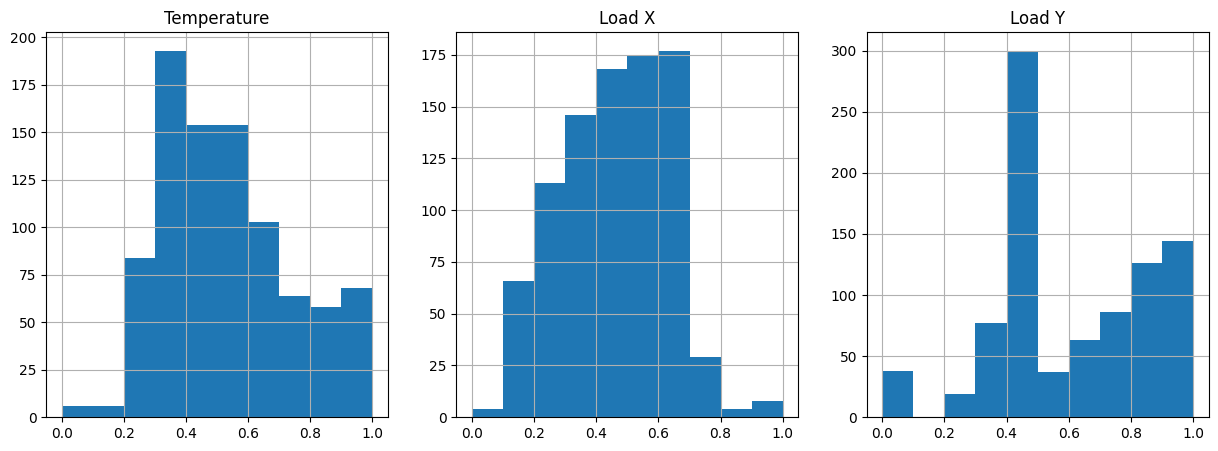

In [241]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

dataset_transformed_df["Temperature"].hist(ax=ax1)
ax1.set_title('Temperature')

dataset_transformed_df["Load X"].hist(ax=ax2)
ax2.set_title('Load X')

dataset_transformed_df["Load Y"].hist(ax=ax3)
ax3.set_title('Load Y')

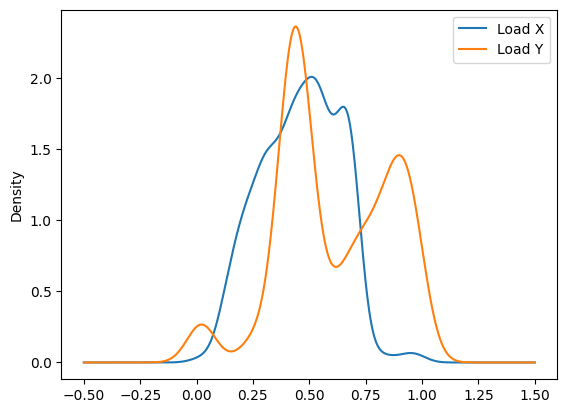

In [242]:
dataset_transformed_df.plot(x="Temperature", y=["Load X", "Load Y"], kind='kde')
plt.show()

In [251]:
# Do one inverse transformation, just for demonstration.
load_y_min = -0.23301682607607901
load_y_max = 686.0612810310728
test_column = dataset_transformed_df['Load Y'].copy()
test_column = test_column * (load_y_max - load_y_min) + load_y_min
test_column = inv_boxcox(test_column, lambda_load_y)

In [252]:
test_column

6     139985.0
7     187225.0
8     185279.0
9     231165.0
10    241922.0
        ...   
85    124135.0
86    124144.0
87    124107.0
88    124193.0
89    124393.0
Name: Load Y, Length: 890, dtype: float64

In [253]:
dataset_transformed_df['Load Y']

6     0.446527
7     0.503198
8     0.501043
9     0.548702
10    0.559044
        ...   
85    0.425001
86    0.425014
87    0.424962
88    0.425083
89    0.425364
Name: Load Y, Length: 890, dtype: float64

In [254]:
dataset_df_raw['Load Y']

1     671413.0
2     738346.0
3     138438.0
4      14598.0
5     141208.0
        ...   
86    124144.0
87    124107.0
88    124193.0
89    124393.0
90    124601.0
Name: Load Y, Length: 1103, dtype: float64

In [255]:
# Compute and visualize covarience and correlation matrices.
features = ["Temperature", "Depth Of Cut", "Feed Rate", "Lenght Of Cut"]
labels = ["Load X", "Load Y"]

In [256]:
# Convert dataset into numpy arrays.
X = dataset_transformed_df[features].to_numpy()
y = dataset_transformed_df[labels].to_numpy()

In [257]:
X_y = np.concatenate((X, y), axis = 1)

In [258]:
X_y_labels = features + labels

In [259]:
# Compute the covariance matrix.
cov_matrix = np.cov(X_y.T, bias = True)
cov_matrix = np.around(cov_matrix, 2)

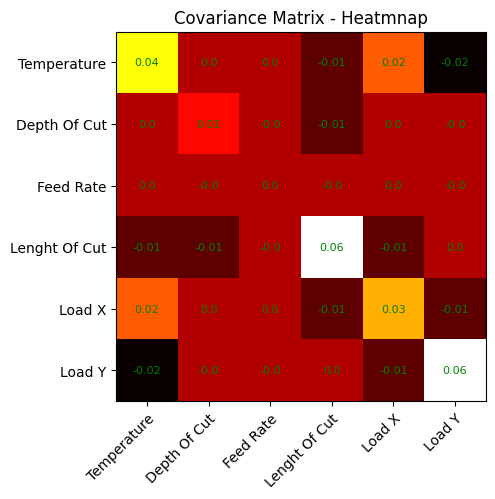

In [260]:
plot_heatmap(cov_matrix, X_y_labels, 'Covariance Matrix')

In [261]:
# Compute the correlation matrix.
corr_matrix = np.corrcoef(X_y.T)
corr_matrix = np.around(corr_matrix, 2)

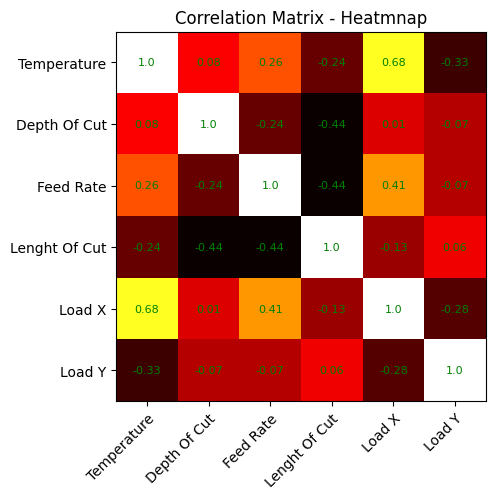

In [262]:
plot_heatmap(corr_matrix, X_y_labels, 'Correlation Matrix')

In [263]:
dataset_transformed_df.head()

,Temperature,Depth Of Cut,Feed Rate,Lenght Of Cut,Load X,Load Y
6,0.278499,0.2,0.2,1.5,0.110789,0.446527
7,0.277456,0.2,0.2,1.5,0.149311,0.503198
8,0.279547,0.2,0.2,1.5,0.155638,0.501043
9,0.280332,0.2,0.2,1.5,0.194172,0.548702
10,0.282088,0.2,0.2,1.5,0.204513,0.559044


In [264]:
# Split the cleaned and transformed data into training and testing sets with a 90/10 ratio.
train_df, test_df = train_test_split(dataset_transformed_df, test_size=0.1, random_state=42)

In [265]:
# Export the data sets.
train_df.to_csv('./data/dataset_train.csv', index=False)
test_df.to_csv('./data/dataset_test.csv', index=False)